In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v003.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import scipy as sp
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

Loading ../data/BIOQIC/fem_box2/90/wave.nc
Loading ../data/BIOQIC/fem_box2/90/mre.nc
Loading ../data/BIOQIC/fem_box2/90/mre_mask.nc


<IPython.core.display.Javascript object>


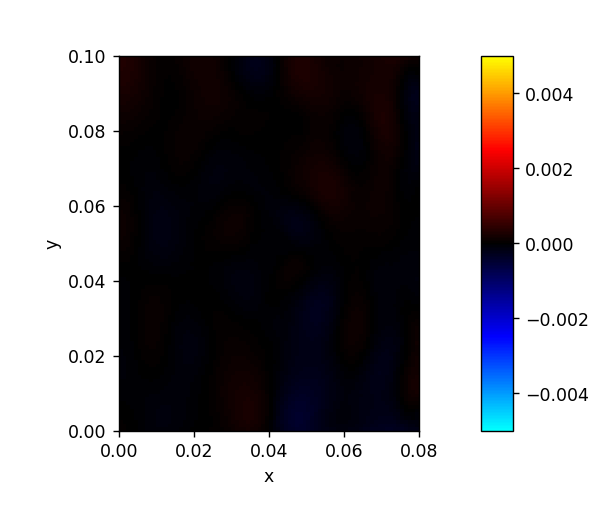

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


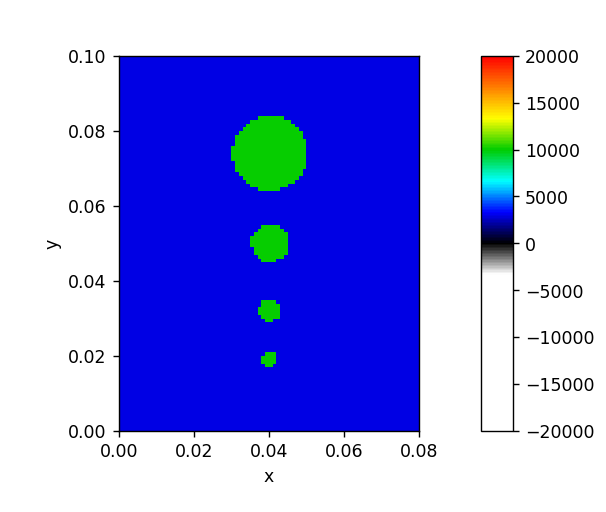

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [3]:
frequency = 90
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box2/', frequency)
example.view('wave', ax_height=3, polar=False, vmax=5e-3)
example.view('mre',  ax_height=3, polar=True,  vmax=20e3)

In [4]:
example.metadata

size  spacing  origin  limit  center  extent
variable dimension                                              
wave     x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre      x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre_mask x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01

In [21]:
#u = example.wave
#mu = example.mre

#N_x, N_y, N_z, N_c = u.shape
N_x, N_y, N_z = (32, 32, 32)

print((N_x, N_y, N_z), N_x*N_y*N_z)

(32, 32, 32) 32768


<IPython.core.display.Javascript object>


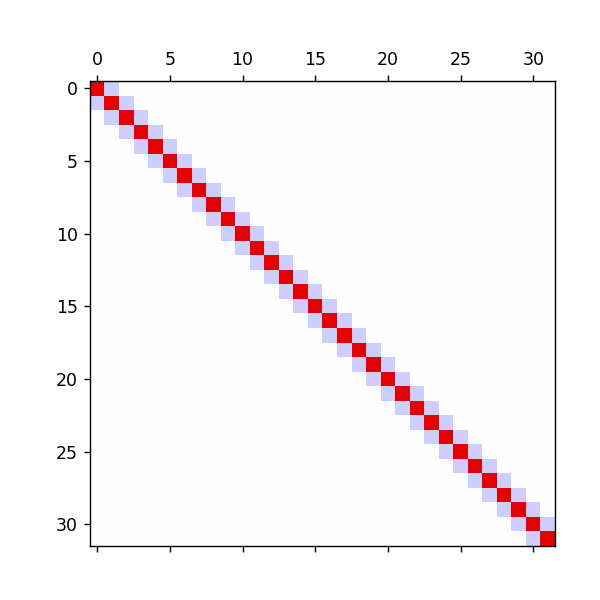

<32x32 sparse matrix of type '<class 'numpy.float64'>'
	with 94 stored elements (3 diagonals) in DIAgonal format>

In [22]:
# construct sparse 1D Laplacian matrix

main = np.full(N_z, -6)
ones = np.ones(N_z - 1)

L1 = sp.sparse.diags([ones, main, ones], [-1, 0, 1])
plt.matshow(L1.A, cmap='seismic_r', vmin=-10, vmax=10)
L1

<IPython.core.display.Javascript object>


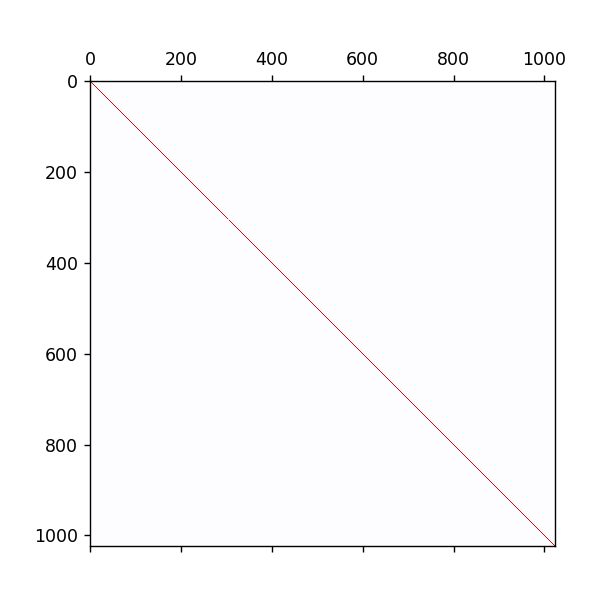

<1024x1024 sparse matrix of type '<class 'numpy.float64'>'
	with 4992 stored elements in Compressed Sparse Row format>

In [23]:
# construct 2D Laplacian matrix

main = [L1 for i in range(N_y)]
ones = np.ones((N_y - 1)*N_z)

L2 = sp.sparse.block_diag(main) + sp.sparse.diags([ones, ones], [-N_z, N_z])
plt.matshow(L2.A, cmap='seismic_r', vmin=-10, vmax=10)
L2

In [24]:
# construct 3D Laplacian matrix

main = [L2 for i in range(N_x)]
ones = np.ones((N_x - 1)*N_y*N_z)

L3 = sp.sparse.block_diag(main) + sp.sparse.diags([ones, ones], [N_y*N_z, -N_y*N_z])
#plt.matshow(L3.A, cmap='seismic_r', vmin=-10, vmax=10)
L3

<32768x32768 sparse matrix of type '<class 'numpy.float64'>'
	with 223232 stored elements in Compressed Sparse Row format>

In [25]:
# compare matmul to convolution

nax = np.newaxis
K = np.zeros((3,3,3))
K[1,1,:] += [1,-2,1]
K[1,:,1] += [1,-2,1]
K[:,1,1] += [1,-2,1]

A = np.random.choice([0,1,2,3], (N_x,N_y,N_z))

result1 = sp.ndimage.convolve(A, K, mode='constant')
result2 = (L3 @ A.flatten()).reshape(A.shape).astype(int)

np.linalg.norm(result1 - result2) / np.linalg.norm(result1)

0.0

<IPython.core.display.Javascript object>


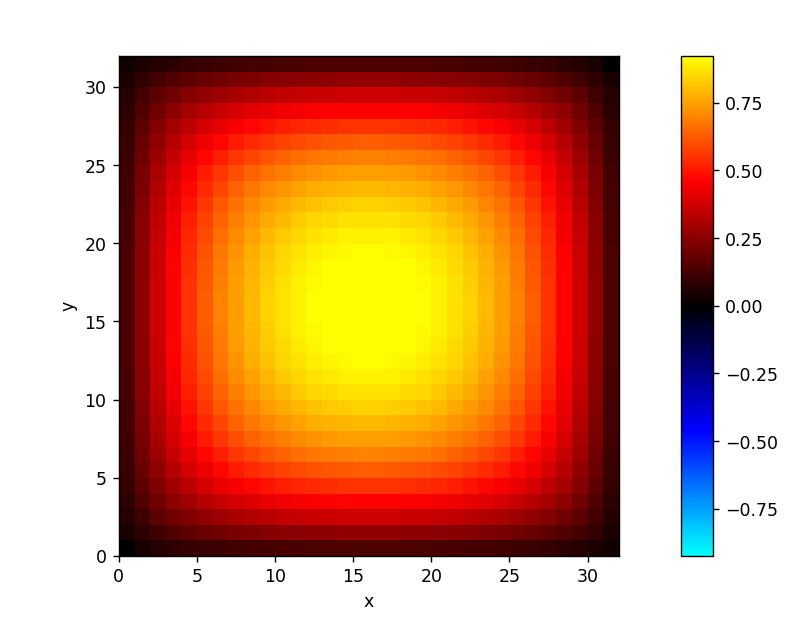

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [28]:
# solve Poisson equation

# coefficent matrix and righthand side (Ax = b)
dx = 2 / N_x
A = L3.copy() / dx**2
b = np.full((N_x, N_y, N_z), -4)
b = b.flatten()

# identify boundary of domain
on_boundary = np.zeros((N_x, N_y, N_z), bool)
on_boundary[:,0,0] = on_boundary[:,-1,-1] = 1
on_boundary[0,:,0] = on_boundary[-1,:,-1] = 1
on_boundary[0,0,:] = on_boundary[-1,-1,:] = 1
on_boundary = on_boundary.flatten()

# establish boundary conditions
I = sp.sparse.identity(N_x * N_y * N_z)
I = sp.sparse.csr_matrix(I)
A[on_boundary] = I[on_boundary]
b[on_boundary] = 0

# solve linear system
u_hat = sp.sparse.linalg.spsolve(A, b).reshape(N_x, N_y, N_z)
u_hat = xr.DataArray(u_hat, dims=['x', 'y', 'z'])
u_hat.name = 'wave field'

mre_pinn.visual.XArrayViewer(u_hat)